In [49]:
import re
import copy
import graphviz
import time

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

from itertools import permutations



class Tunnel:
    def __init__(self, source, flow_rate, targets):
        self.source = source
        self.flow_rate = flow_rate
        self.targets = targets
        self.paths = {}
        
    def get_path(self, tunnel):
        if tunnel in self.paths:
            return self.paths[tunnel]
        
        if self == tunnel:
            return []
        
        seen = {self}
        queue = [(target, [target]) for target in self.targets]
        while queue:
            next_, path = queue.pop(0)
            if next_ in seen:
                continue
                
            seen.add(next_)
            
            if next_.source == tunnel.source:
                self.paths[next_] = path
                return path
            
            queue.extend([(target, path + [target]) for target in next_.targets])
            
        raise Exception('No path found')
        
    def __str__(self):
        return f"{self.source}:{self.flow_rate}"
    
    def __repr__(self):
        return self.__str__()
    
    def __hash__(self):
        return hash(self.source)

class TunnelSystem:
    def __init__(self, t=30, name='me'):
        self.tunnels = []
        self.enabled = set()
        self.order = []
        self.path = []
        self.positions = None
        self.t = t
        self.name = name
        
    
    def register_tunnel(self, tunnel):
        self.tunnels.append(tunnel)
        # always start at AA
        if tunnel.source == 'AA':
            self.position = tunnel
            self.path.append(('START', self.position))

    def hydrate_tunnels(self):
        self.mapping = {tunnel.source: tunnel for tunnel in self.tunnels}
        
        for tunnel in self.tunnels:
            targets = []
            for target in tunnel.targets:
                targets.append(self.mapping[target])
            
            tunnel.targets = targets

        self.priority = self.get_priority()
    

    def copy(self):
        ts = TunnelSystem()
        
        ts.name = self.name
        ts.tunnels = self.tunnels
        
        ts.enabled = self.enabled.copy()
        ts.order = copy.copy(self.order)
        ts.path = copy.copy(self.path)
        
        ts.position = self.position
        ts.t = self.t
        
        return ts

    def is_done(self):
        return self.t == 0 or not self.get_priority()
    
    def get_potential_value(self):
        sum_ = 0
        
        for tunnel in self.tunnels:
            if not tunnel.flow_rate or tunnel in self.enabled:
                continue
            distance = self.get_distance(tunnel)
            total_time_possible = max(self.t - distance, 0)
            potential_value = tunnel.flow_rate * total_time_possible
            sum_ += potential_value
        
        return sum_
    
    def get_score_upper_bound(self):
        return self.evaluate() + self.get_potential_value()
    
    def get_states(self, n=1):
        next_targets = self.get_next_targets(n=n)
        if not next_targets:
            return []
        
        states = []
        for next_target in next_targets:
            path = self.position.get_path(next_target)
            moves = []
            for node in path:
                move = ('MOVE', node)
                moves.append(move)

            moves.append(('OPEN', next_target))
            
            ts = self.copy()
            for move in moves:
                ts.move(move)
            states.append(ts)
            
        return states

        
    def get_distance(self, tunnel):
        path = self.position.get_path(tunnel)
        return len(path)
    
    def move(self, movement):
        action, target = movement
        self.path.append(movement)
        if action == 'OPEN':
            self.t -= 1
            self.enabled.add(target)
            self.order.append((target, self.t))
            
        if action == 'MOVE':
            self.t -= 1
            self.position = target    

            
    def evaluate(self):
        values = [tunnel.flow_rate * t for tunnel, t in self.order if t >0]
        return sum(values)
    
    def __str__(self):
        return f"{self.name}:p{self.position}:t{self.t}:s{self.evaluate()}"

    def __repr__(self):
        return self.__str__()
    
    def get_steps(self):
        steps = []
        for i, movement in enumerate(self.path):
            action, position = movement
            steps.append(f"{str(i)}-{action}")
        return steps
    
    def get_viz(self):
        dot = graphviz.Digraph(comment='Tunnel System')

        for tunnel in self.tunnels:
            steps = []
            for i, movement in enumerate(self.path):
                action, position = movement
                if position.source == tunnel.source:
                    steps.append(f"{str(i)}-{action}")
            dot.node(tunnel.source, f"{tunnel} {steps}")
        for tunnel in self.tunnels:
            for target in tunnel.targets:
                dot.edge(tunnel.source, target.source)

        return dot
            
    def get_score(self, tunnel):
        distance = self.get_distance(tunnel)
        total_time_possible = max(self.t - distance, 0)
        if not total_time_possible:
            return 0
        return  tunnel.flow_rate ** (1/distance)
    
    def get_priority(self, threshold=0):
        to_visit = []
        for tunnel in self.tunnels:
            if tunnel.flow_rate != 0 and tunnel not in self.enabled:
                value = self.get_score(tunnel)
                if value >= threshold:
                    to_visit.append((tunnel, value))
        
        priority = sorted(to_visit, key=lambda t: -t[1])
        
        return priority
    
    
    def get_next_targets(self, n=1):
        priority = self.get_priority()
        if not priority:
            return None
#         if len(priority) >= 14:
#             print(self.name, priority)
        return [tunnel for tunnel, value in priority][:n]
    
    def get_order(self):
        return [target.source for target, t in self.order]
    
def get_new_states(me, el, n=2):
    queue = []
    if not (me.is_done() and el.is_done()):
        my_states = me.get_states(n)
        
        for my_state in my_states:
            el_copy = el.copy()
            el_copy.enabled = my_state.enabled.union(el.enabled)
            el_copy_states = el_copy.get_states(n)
            for el_state in el_copy_states:
                my_copy = my_state.copy()
                my_copy.enabled = my_copy.enabled.union(el_state.enabled)
                queue.append((my_copy, el_state))
                
            if not el_copy_states:
                queue.append((my_state, el_copy))
            
    elif not me.is_done():
        el_states = el.get_states(n)
        for el_state in el_states:
            queue.append((me, el_state))
    elif not el.is_done():
        me_states = me.get_states(n)
        for me_state in me_states:
            queue.append((me_state, el))

    return queue

def maximize(state, n=2, prev_max=0):
    elephant = state.copy()
    elephant.name = 'elephant'
    queue = get_new_states(state, elephant, n)
    max_ = prev_max
    max_state = None
    while queue:
        me, el = queue.pop()

            
        if me.is_done() and el.is_done():            
            score = me.evaluate() + el.evaluate()
            if score > max_:
                print('new high score', score)
                max_ = max(score, max_)
                max_state = (me, el)
            
            continue
            
        if me.get_score_upper_bound() + el.get_score_upper_bound() <= max_:
            continue
                
        new_states = get_new_states(me, el, n)
        queue.extend(new_states)
        
    
    return max_, max_state
    

with open('../inputs/16.txt') as f:
    ts = TunnelSystem(t=26)
    for line in f:
        result = re.search(r"Valve ([A-Z]+) has flow rate=([0-9]+); tunnels? leads? to valves? (.*)", line)
        
        groups = result.groups()
        
        source, flow_rate, targets = groups[0], int(groups[1]), groups[2].split(', ')
        tunnel = Tunnel(source, flow_rate, targets)
        ts.register_tunnel(tunnel)
        
    ts.hydrate_tunnels()
    
    max_score = 2575

    flow = [tunnel for tunnel in ts.tunnels if tunnel.flow_rate > 0]
    print(flow)
    i = len(flow)
    print(f'Running with {i} branches')
    max_score, systems = maximize(ts.copy(), i, max_score)

    if systems:
        my, el = systems
        print('final orders', my.order, my.evaluate(), el.order, el.evaluate(), sep='\n')
        print(max_score)
    print()
    time.sleep(1)

# JJ, BB, CC 
# DD, HH, EE
        
my.get_viz()

[CG:10, RC:18, GJ:21, QO:24, AJ:12, WI:13, VD:17, ZR:11, PI:4, FR:22, LM:3, KU:9, FV:23, AX:5, OF:19]
Running with 15 branches
new high score 2584
new high score 2587


KeyboardInterrupt: 

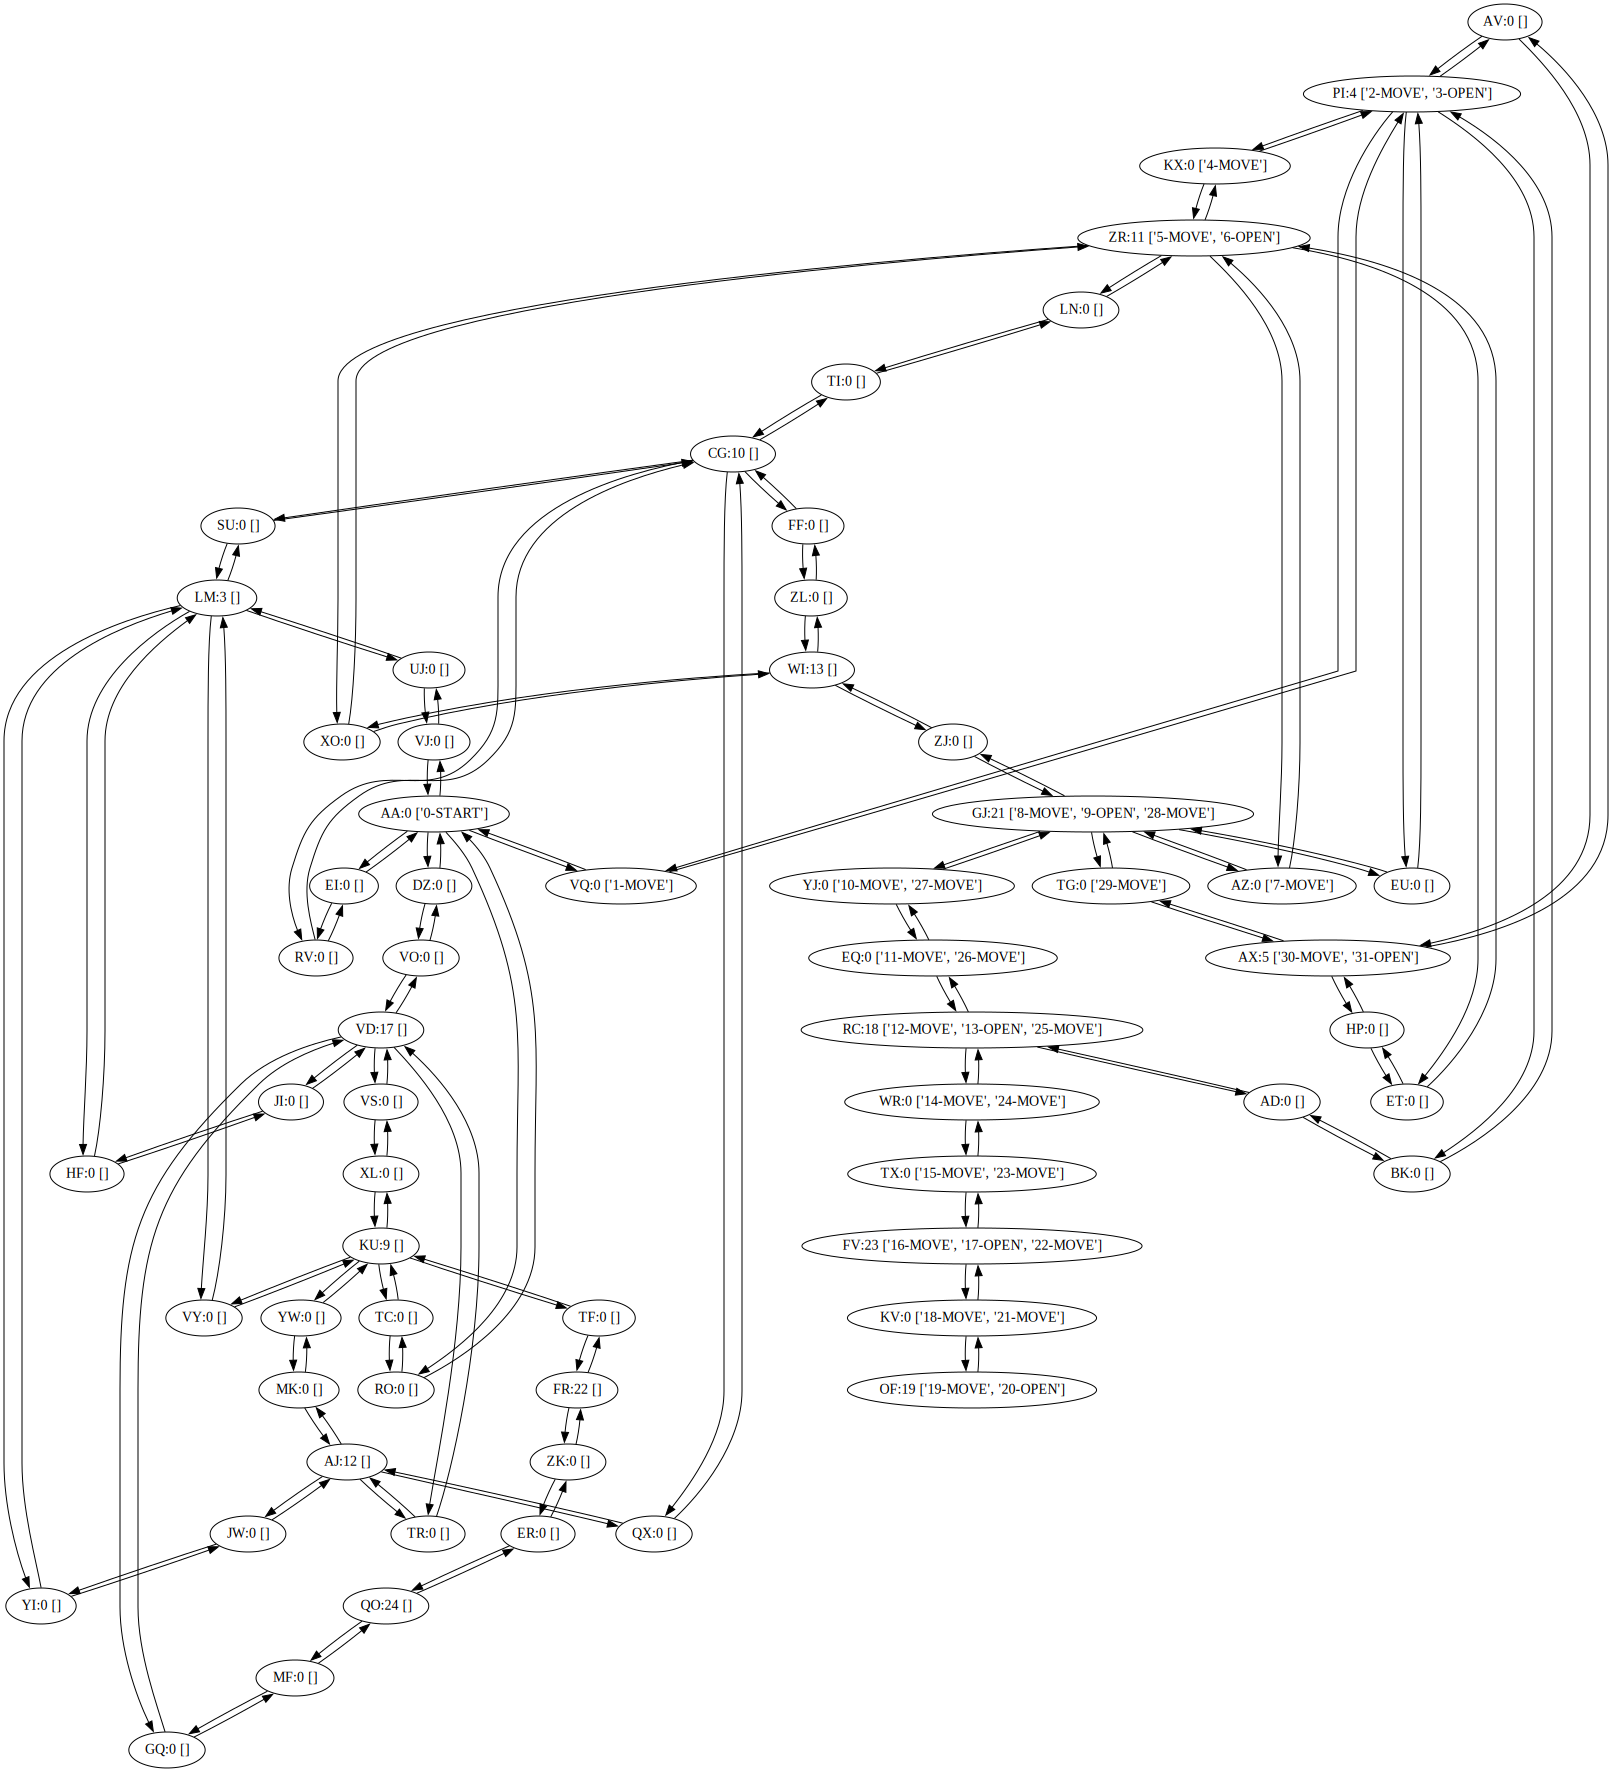

In [41]:
el.get_viz()

In [ ]:
# for main
# 2507 too low
# 2518 too low. reachable with 4 branches.
# 2519 too low, but i just guessed this
# 2520 too low, but guessed
# 2521 too low, but i guessed
# 2525, guess
# 2600 too high
# 2587 shoudl be the answer. i had a bug in my code where i was including scores with negative t in my evaluation. dumdum.



# for alt
# 1914 too low
# 2000 too low but i guessed
# 